In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

import torch.optim as optim

In [2]:
Data = [[torch.Tensor([1, 0]), torch.Tensor([2])], [torch.Tensor([0, 1]), torch.Tensor([1])]]
def loss_func(pred, y): return (pred-y)**2

In [3]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.Tensor([0.5, 3]), requires_grad=True)
        self.scale = torch.nn.Parameter(torch.Tensor([0.5]), requires_grad=True)
    def forward(self, x):
        return x @ self.weight * self.scale

In [4]:
def train(index = 0, num_global_iters = 50, num_local_iters = 10, local_iter_thres = None,  lr = 0.1):
    server_model = Model()
    client_models = [copy.deepcopy(server_model) for i in range(2)]

    memory = list()
    memory.append(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy())
    memory_w = list()
    memory_w.append(server_model.weight.data.detach().cpu().numpy())
    memory_loss = list()
    for epoch in range(num_global_iters):  
        
        client_models = [copy.deepcopy(server_model) for i in range(2)]
        optimizers = [optim.SGD(client_models[idx].parameters(), lr=lr) for idx in range(2)]
        
        for client_idx in range(2):
            model, optimizer = client_models[client_idx], optimizers[client_idx]
            X, Y = Data[client_idx]
            for local_iter in range(num_local_iters):
                
                if local_iter_thres == None: model.weight.requires_grad = True
                elif local_iter < local_iter_thres: model.weight.requires_grad = False
                
                pred = model(X)
                loss = loss_func(pred, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        with torch.no_grad():
            server_model.weight.data.copy_(copy.deepcopy((client_models[0].weight.data + client_models[1].weight.data)/2))
            server_model.scale.data.copy_(copy.deepcopy((client_models[0].scale.data + client_models[1].scale.data)/2))
            memory.append(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy())
            memory_w.append(server_model.weight.data.detach().cpu().numpy())
            loss = 0
            for client_idx in range(2):
                X, Y = Data[client_idx]
                pred = server_model(X)
                loss += loss_func(pred, Y).item() / 2
            memory_loss.append(loss)
    memory = np.array(memory)
    memory_loss = np.array(memory_loss)
    return memory, memory_loss, memory_w

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


([<matplotlib.lines.Line2D at 0x7f6d85747310>],
 <matplotlib.legend.Legend at 0x7f6d8571a980>)

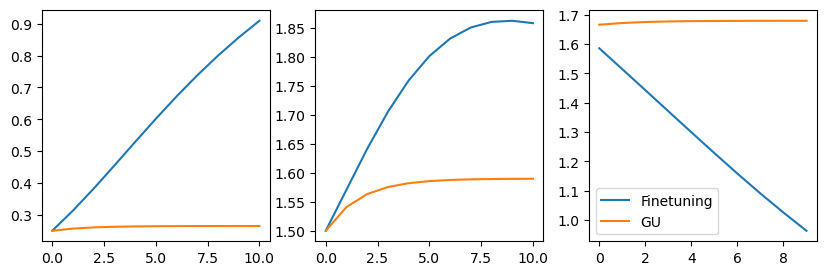

In [5]:
memory, memory_loss, memory_w = train(index = 0, num_global_iters = 10, num_local_iters = 10, local_iter_thres = None,  lr = 0.01)
memory2, memory_loss2, memory_w2 = train(index = 0, num_global_iters = 10, num_local_iters = 10, local_iter_thres = 2,  lr = 0.01)

fig, axes = plt.subplots(1,3,figsize=(10,3))
ax = axes[0]
ax.plot(memory[:,0], label="Finetuning"), ax.plot(memory2[:,0], label="GU"), plt.legend()
ax = axes[1]
ax.plot(memory[:,1], label="Finetuning"), ax.plot(memory2[:,1], label="GU"), plt.legend()
ax = axes[2]
ax.plot(memory_loss, label="Finetuning"), ax.plot(memory_loss2, label="GU"), plt.legend()